# 1. Introduction


**Import all Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

# 2. Data preparation
## 2.1 Load data

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [ ]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


**Set data features and labels**

In [ ]:
X = train.drop(['label'], axis=1).values
y = train['label'].values

## 2.2 Normalization

The activation values of X range from 0 to 255.
Normalize them to have a range of 0 to 1



In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X)

normalized_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 2.3 Reshape

> Indented block

> Indented block





In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
# current X.shape = (42000, 28, 28, 3)
# desired X.shape = (42000, 28, 28, 1)
X = X.reshape(42000, 28, 28, 1)
X.shape

(42000, 28, 28, 1)

## 2.4 Label encoding

**One-Hot Encoding**

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y) # You should use Keras to do this
# previous y.shape = (42000, 1)
print(f"Label size {y.shape}")

Label size (42000, 10)


Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set

In [ ]:
# Split the train and the validation set for the fitting
# Decide the val_size and read more about random_state https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape # Can you explain these numbers based on the val_size that you set?

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

**Data Visualization**

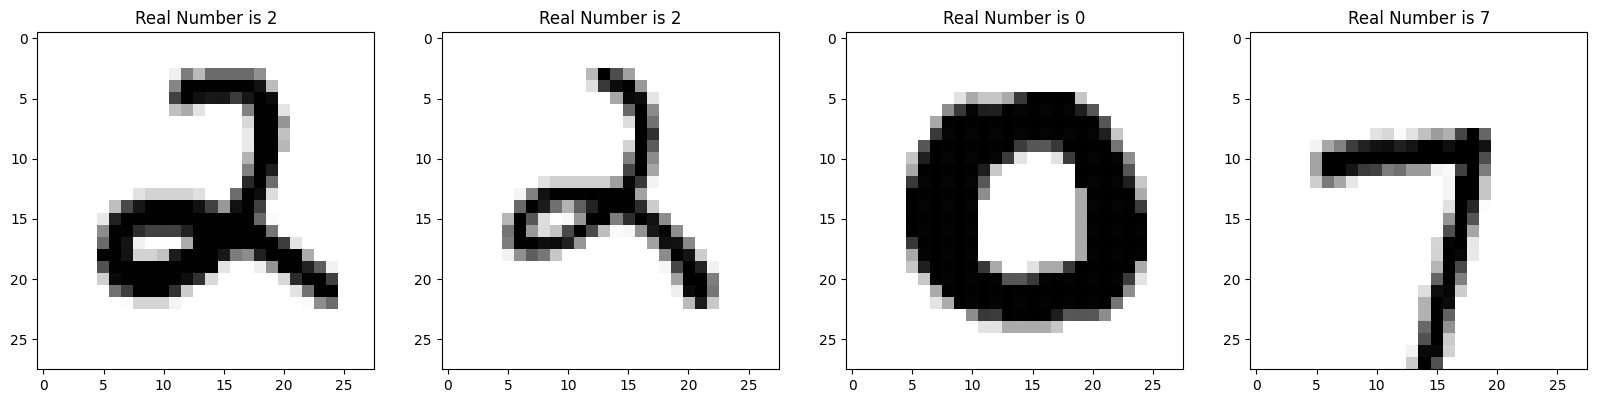

In [ ]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization**

In [ ]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (X - mean) / std # Normalize x using mean and std

# 3. CNN
## 3.1 Define the model

**Model Definition**

In [ ]:
# Change the layers of the model
# Add padding and strides wherever required

model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", padding="same", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation="relu"))

model.add(Dense(10,activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,682 (2.64 MB)

 Trainable params: 691,786 (2.64 MB)

 Non-trainable params: 896 (3.50 KB)

## 3.3 Model training

In [ ]:
model.fit(X, y, batch_size=128, validation_split=0.2, epochs=10) # Change the batch_size and epochs
# Number of images in X = 42000
# Validation split = 20%, so the number of images undergoing training = 80% * 42000 = 33600 = 263 * 128

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 0.9913 - val_loss: 0.0432
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.9979 - loss: 0.0062 - val_accuracy: 0.9929 - val_loss: 0.0377
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9881 - val_loss: 0.0590
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.9960 - loss: 0.0119 - val_accuracy: 0.9887 - val_loss: 0.0608
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9961 - loss: 0.0142 - val_accuracy: 0.9908 - val_loss: 0.0522
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9970 - loss: 0.0099 - val_accuracy: 0.9899 - val_loss: 0.0609
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.9917 - val_loss: 0.0598
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9981 - loss: 0.0059 - val_accu

## 4.2 Confusion matrix

132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step


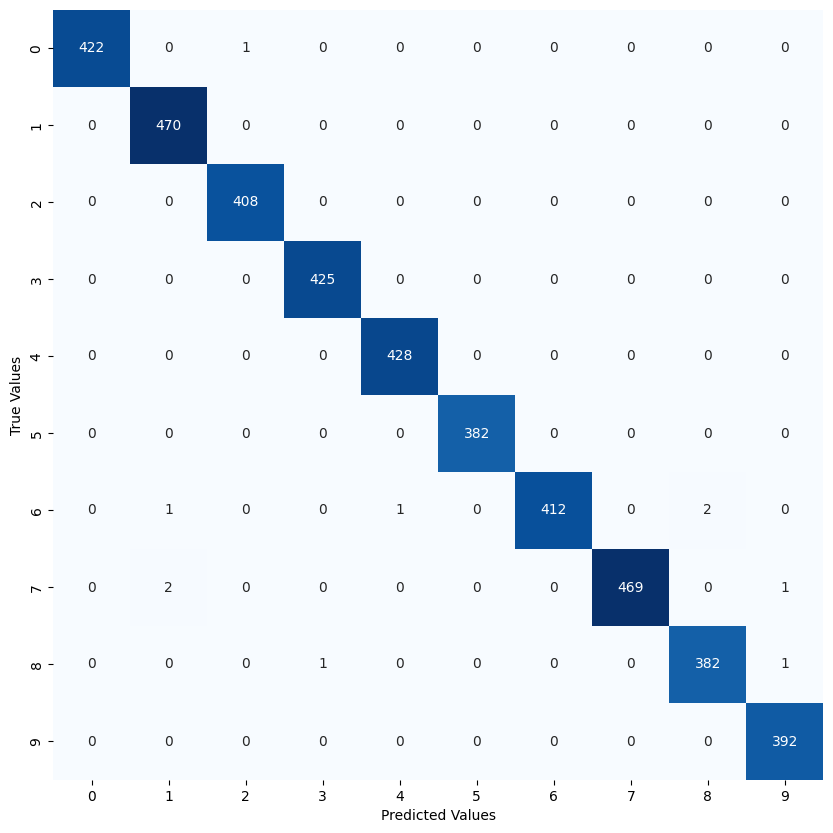

In [ ]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_val) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_val, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

# 5. Prediction and submission




## 5.1 Prediction validation results

132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step


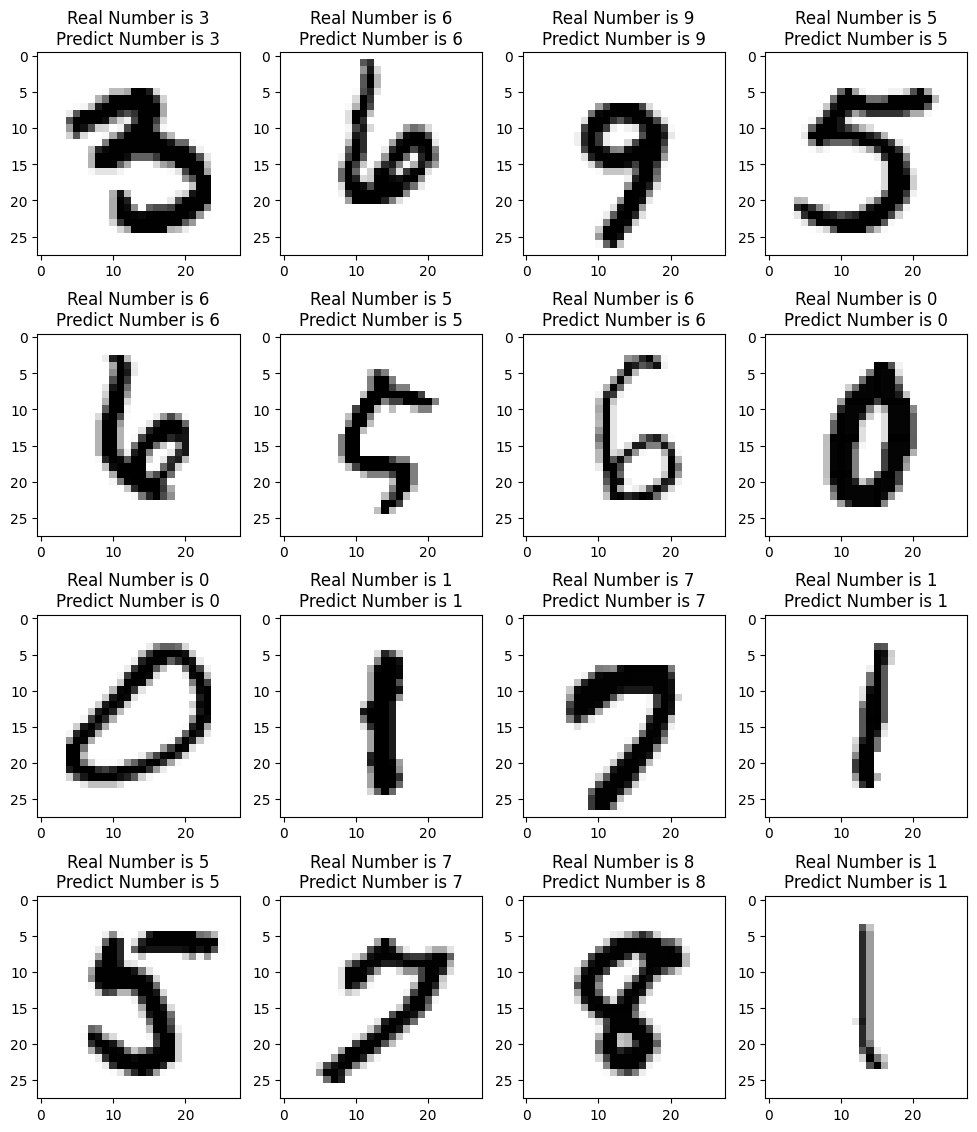

In [ ]:
y_pred = model.predict(X_val)
X_val__ = X_val.reshape(X_val.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_val__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_val[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## 5.2 Submission

In [ ]:
# preprocess test data
test_x = test.values
test_x =test_x/255.0 # Normalize the activation values from [0,255] to [0,1]
test_x = test_x.reshape(-1,28,28,1) # Reshape the test data from 3 RGB channels to a single grayscale channel

# predict test data
#pred = model.predict_classes(test_x, verbose=1)
pred = model.predict(test_x)
classes_x = np.argmax(pred, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step


In [ ]:
# submissions
sub['Label'] = pred
sub.to_csv("CNN_keras_sub.csv", index=False)
sub.head()

,ImageId,Label
0,1,5.297814e-09
1,2,5.283062e-09
2,3,5.158309e-09
3,4,5.271295e-09
4,5,5.246400e-09
